In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from itertools import product

from collections import defaultdict
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5 # the relative size  of legend markers vs original
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .4 # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = .5
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# Продолжительность пользовательских сессий
Сгенерим синтетические данные со средней продолжительностью пользовательских сессий

In [3]:
group_size = 100
np.random.seed(33)
df_pilot = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})
df_control = pd.DataFrame({'y_before': np.random.normal(120, 40, group_size)})

In [4]:
df_pilot['y'] = df_pilot['y_before'] + np.random.normal(0, 10, group_size)
df_control['y'] = df_control['y_before'] + np.random.normal(0, 10, group_size)

df_pilot['y'] += np.random.normal(5, 2, group_size)

In [5]:
df_pilot.head()

,y_before,y
0,107.245860,117.249746
1,55.880778,64.625057
2,58.591285,54.735771
3,97.183964,105.821062
4,111.330868,117.212246


In [6]:
df_pilot.mean().round(1)

y_before    118.5
y           123.9
dtype: float64

In [7]:
df_control.mean().round(1)

y_before    114.2
y           116.1
dtype: float64

Видим, что средние стли отличаться в пилотной группе значений больше,
Проверим значимость отличий.

In [8]:
_, pvalue_prepilot = ttest_ind(df_pilot['y_before'], df_control['y_before'])
_, pvalue_pilot = ttest_ind(df_pilot['y'], df_control['y'])
print(f'pvalue prepilot {pvalue_prepilot:.3f}')
print(f'pvalue pilot {pvalue_pilot:.3f}')

pvalue prepilot 0.475
pvalue pilot 0.209


Отличия не значимы, применим CUPED

In [9]:
def calculate_theta(y_control, y_pilot, y_control_cov, y_pilot_cov) -> float:
    """Вычисляем Theta.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    y_cov = np.hstack([y_control_cov, y_pilot_cov])
    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return theta

In [10]:
theta = calculate_theta(
    df_control['y'], df_pilot['y'],
    df_control['y_before'], df_pilot['y_before']
)

for df_ in [df_pilot, df_control]:
    df_['y_cuped'] = df_['y'] - theta * df_['y_before']

_, pvalue_cuped = ttest_ind(df_pilot['y_cuped'], df_control['y_cuped'])
print(f'pvalue cuped {pvalue_cuped:.3f}')

pvalue cuped 0.014


Получили значимый эффект, посмотрим как изменились дисперсия и разница средних

In [11]:
var_y_pilot = df_pilot['y'].var()
var_y_control = df_control['y'].var()
var_y_cuped_pilot = df_pilot['y_cuped'].var()
var_y_cuped_control = df_control['y_cuped'].var()

delta_y = df_pilot['y'].mean() - df_control['y'].mean()
delta_y_cuped = df_pilot['y_cuped'].mean() - df_control['y_cuped'].mean()

print(
    f'pilot group\n    var(y)={var_y_pilot:.1f}\n    var(y_cuped) = {var_y_cuped_pilot:.1f}'
    f'\n    var(y)/var(y_cuped) = {var_y_pilot/var_y_cuped_pilot:.2f}'
)

print(
    f'control group\n    var(y)={var_y_control:.1f}\n    var(y_cuped) = {var_y_cuped_control:.1f}'
    f'\n    var(y)/var(y_cuped) = {var_y_control/var_y_cuped_control:.2f}'
)

print(f'\ndelta_y = {delta_y:.2f}\ndelta_y_cuped = {delta_y_cuped:.2f}')

pilot group
    var(y)=1842.7
    var(y_cuped) = 101.6
    var(y)/var(y_cuped) = 18.14
control group
    var(y)=1920.2
    var(y_cuped) = 86.6
    var(y)/var(y_cuped) = 22.16

delta_y = 7.73
delta_y_cuped = 3.41


# Как влияет $\theta$ на уменьшение дисперсии

In [12]:
theta

1.0208548812876632

In [13]:
thetas = np.linspace(.5, 1.5, 101)
list_var_y_cuped_pilot = []
list_var_y_cuped_control = []
for theta_ in thetas:
    for df_ in [df_pilot, df_control]:
        df_['y_cuped_'] = df_['y'] - theta_ * df_['y_before']
    var_y_cuped_pilot = df_pilot['y_cuped_'].var()
    var_y_cuped_control = df_control['y_cuped_'].var()
    list_var_y_cuped_pilot.append(var_y_cuped_pilot)
    list_var_y_cuped_control.append(var_y_cuped_control)

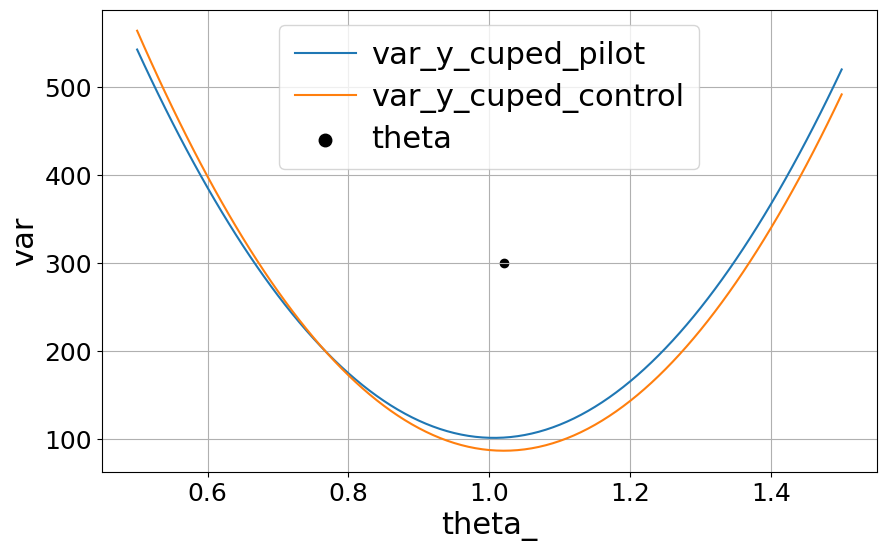

In [14]:
plt.plot(thetas, list_var_y_cuped_pilot, label='var_y_cuped_pilot')
plt.plot(thetas, list_var_y_cuped_control, label='var_y_cuped_control')
plt.scatter([theta], [300], label='theta', c='k')
plt.xlabel('theta_')
plt.ylabel('var')
plt.grid()
plt.legend();
plt.show()

Видно, что $\theta$ подобрана достаточно оптимально

# Продажа минералки

Пилот направлен на увеличение продажи минеральной воды. Продажа минеральной воды зависит от тепмературы воздуха на
улице, чем жарче, тем продажи больше.

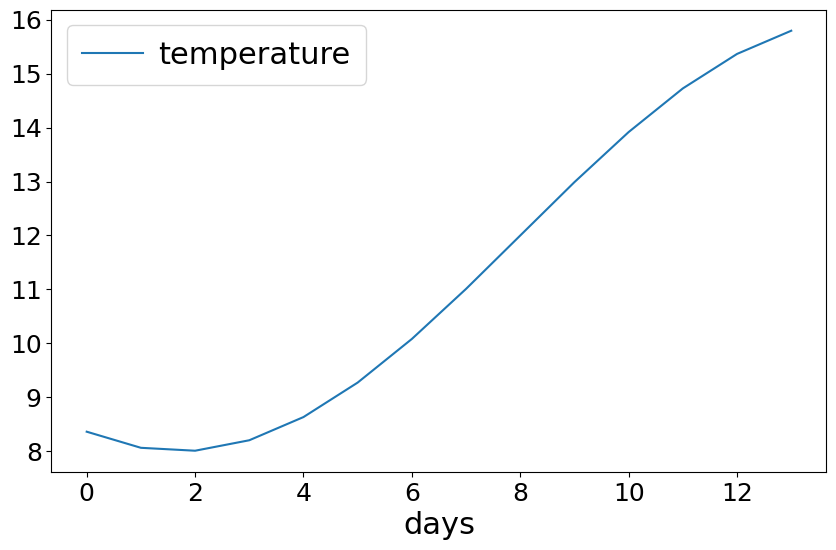

In [15]:
days = np.arange(14)
temperature = (np.sin((days - 8)/4) + 3) * 4
plt.plot(days, temperature, label='temperature')
plt.legend()
plt.xlabel('days')
plt.show()

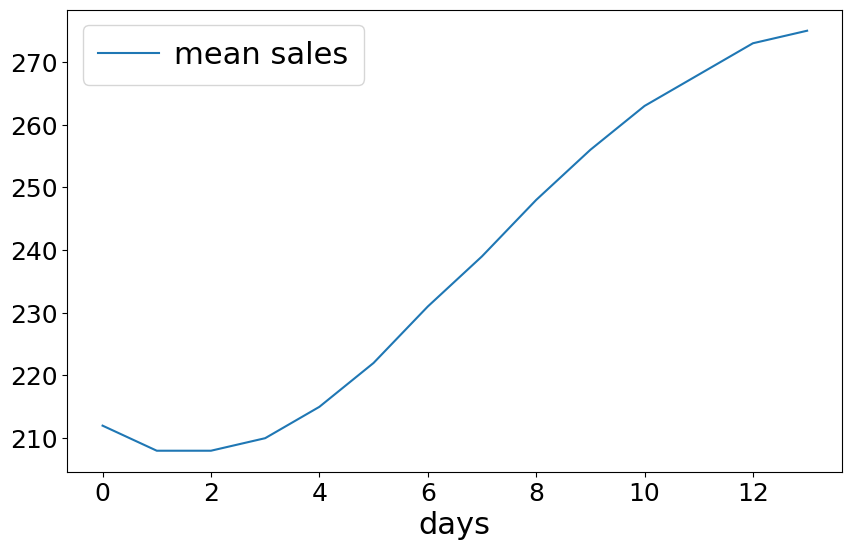

In [16]:
mean_sales = (np.log(temperature) * 100).astype(int)
plt.plot(days, mean_sales, label='mean sales')
plt.legend()
plt.xlabel('days')
plt.show()

Пилот проводится во вторые 7 дней. У нас есть данные из 10 магазинов: 5 контрольных и 5 пилотных

In [17]:
np.random.seed(44)

df_mean_sales = pd.DataFrame({'day': days, 'temperature': temperature.round(1), 'mean_sales': mean_sales})

shops = np.arange(10)
df = pd.DataFrame(product(days, shops), columns=('day', 'shop'))
df['pilot'] = (df['shop'] < 5).astype(int)
df = pd.merge(df, df_mean_sales, on='day')

df['y'] = df['mean_sales'] + np.random.normal(0, 10, len(df)).astype(int)

# добавим эффект
mask_pilot = (df['pilot'] == 1) & (df['day'] >= 7)
df.loc[mask_pilot, 'y'] += np.random.normal(9, 10, mask_pilot.sum()).astype(int)
df.sample(5)

,day,shop,pilot,temperature,mean_sales,y
16,1,6,0,8.1,208,218
81,8,1,1,12.0,248,249
131,13,1,1,15.8,275,288
87,8,7,0,12.0,248,260
38,3,8,0,8.2,210,207


Посмотрим, как менялись продажи в магазинах пилотной и контрольной групп

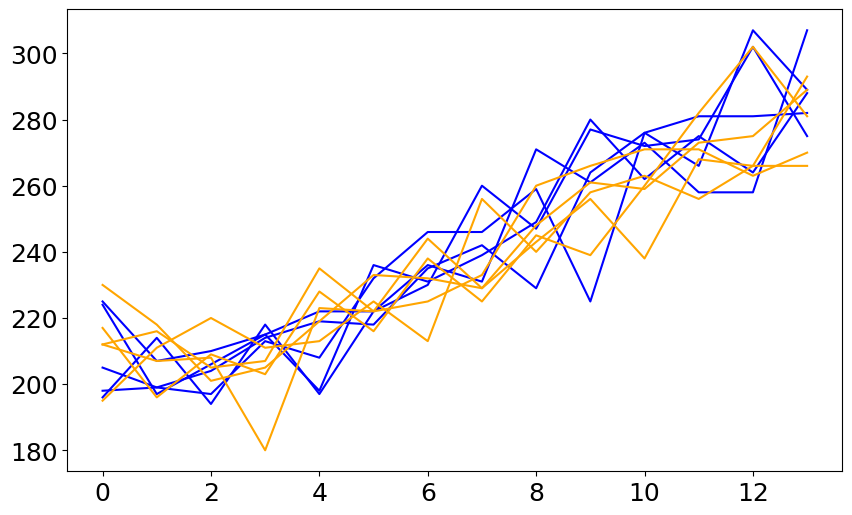

In [18]:
for shop, df_ in df.groupby('shop'):
    df_ = df_.sort_values('day')
    color = 'blue' if shop < 5 else 'orange'
    plt.plot(df_['day'].values, df_['y'].values, c=color)
plt.show()

<Axes: xlabel='day'>

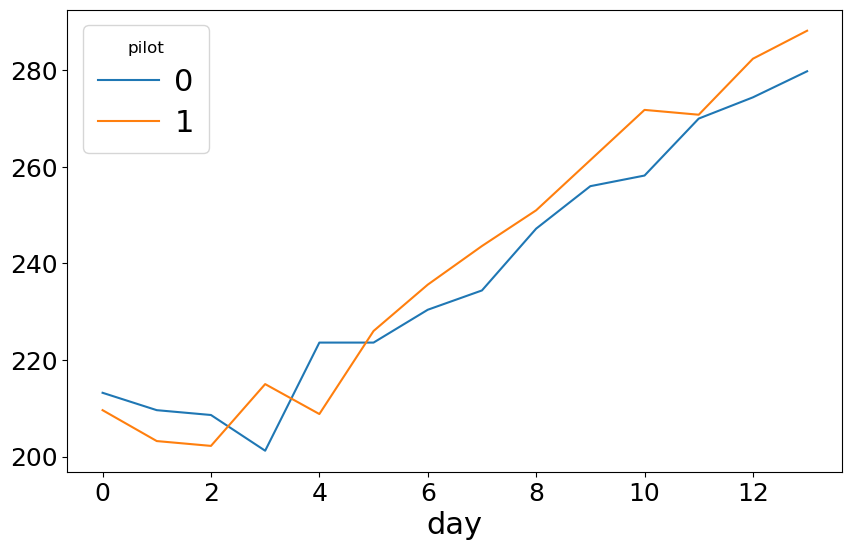

In [19]:
(
    df
    .groupby(['pilot', 'day'])[['y']].mean()
    .reset_index()
    .pivot(columns='pilot', index='day', values='y')
    .plot()
)

Среднее пилотной группы во время пилота, как правило, чуть больше среднего контрольной группы.
Проверим статзначимость

In [20]:
index_pilot = df[(df['pilot'] == 1) & (df['day'] >= 7)].sort_values(['shop', 'day']).index.values
index_control = df[(df['pilot'] == 0) & (df['day'] >= 7)].sort_values(['shop', 'day']).index.values
index_pilot_before = df[(df['pilot'] == 1) & (df['day'] < 7)].sort_values(['shop', 'day']).index.values
index_control_before = df[(df['pilot'] == 0) & (df['day'] < 7)].sort_values(['shop', 'day']).index.values

delta_y = df.loc[index_pilot, 'y'].mean() - df.loc[index_control, 'y'].mean()
_, pvalue = ttest_ind(df.loc[index_pilot, 'y'], df.loc[index_control, 'y'])
print(f'delta_y = {delta_y:.2f}')
print(f'pvalues = {pvalue:.2f}')

delta_y = 7.03
pvalues = 0.13


In [21]:
df.loc[index_pilot, 'y'].shape

(35,)

In [22]:
theta = calculate_theta(
    df.loc[index_control, 'y'], df.loc[index_pilot, 'y'],
    df.loc[index_control_before, 'y'], df.loc[index_pilot_before, 'y']
)

y_cuped_pilot = df.loc[index_pilot, 'y'].values - theta * df.loc[index_pilot_before, 'y'].values
y_cuped_control = df.loc[index_control, 'y'].values - theta * df.loc[index_control_before, 'y'].values

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = ttest_ind(y_cuped_pilot, y_cuped_control)

print(f'delta_y_cuped = {delta_y_cuped:.2f}')
print(f'pvalue cuped {pvalue_cuped:.2f}')

delta_y_cuped = 7.67
pvalue cuped 0.01


Нулевая гипотеза опять не отвергается, посмотрим как изменилась дисперсия

In [23]:
np.var(y_cuped_pilot), np.var(df.loc[index_pilot, 'y'].values)

(342.83397911343116, 402.42775510204086)

In [24]:
theta = calculate_theta(
    df.loc[index_control, 'y'], df.loc[index_pilot, 'y'],
    df.loc[index_control_before, 'temperature'], df.loc[index_pilot_before, 'temperature']
)

y_cuped_pilot = df.loc[index_pilot, 'y'].values - theta * df.loc[index_pilot_before, 'temperature'].values
y_cuped_control = df.loc[index_control, 'y'].values - theta * df.loc[index_control_before, 'temperature'].values

delta_y_cuped = y_cuped_pilot.mean() - y_cuped_control.mean()
_, pvalue = ttest_ind(y_cuped_pilot, y_cuped_control)

print(f'delta_y_cuped = {delta_y_cuped:.2f}')
print(f'pvalue cuped {pvalue_cuped:.2f}')

delta_y_cuped = 7.03
pvalue cuped 0.01


In [25]:
np.var(y_cuped_pilot), np.var(df.loc[index_pilot, 'y'].values)

(271.8113815886342, 402.42775510204086)

# 3. CUPED + ML